In [47]:
%matplotlib inline

In [3]:
import pandas as pd
from fastcore import *
from fastcore.all import * 

In [12]:
base_path = Path('/mnt/c/trial/results')

In [14]:
experiments = base_path.ls()
experiments

(#1) [Path('/mnt/c/trial/results/matancohen')]

In [15]:
exp = Path('/mnt/c/trial/results/matancohen')

In [42]:
def read_file(file_name):
    with open(file_name, 'r') as file:
        lines = file.read().splitlines()
        
    d = {}
    for l in lines:
        value = l.split(':')
        d[value[0]] = value[1]
    
    return d

In [48]:
df = pd.DataFrame([read_file(file_name) for file_name in exp.ls()])

In [59]:
df = df.astype({'nclauses': int, 'num_assignments': int, 'num_backtracks': int, 'num_decisions': int, 'num_learned': int, 'nvars': int, 'runtime': float,})

<AxesSubplot:xlabel='nclauses', ylabel='runtime'>

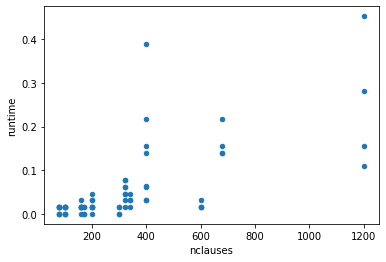

In [61]:
df.plot(x='nclauses', y='runtime', kind='scatter')